In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date

last_entry = session.query(Measurement.date).order_by(Measurement.date.desc()).all()[0][0]
last_year = dt.datetime.strptime(last_entry, '%Y-%m-%d') - dt.timedelta(days=365)
prcp_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= last_year).order_by(Measurement.date).all()

prcp_df = pd.DataFrame(prcp_data, columns=['date', 'prcp']).fillna(0).set_index('date')
prcp_df.head(10)

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,0.00
2016-08-24,1.22
2016-08-24,2.15
2016-08-24,1.45
2016-08-25,0.08
2016-08-25,0.08


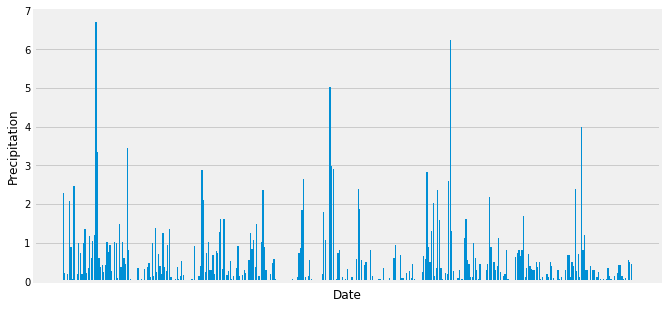

In [11]:
# Use Pandas Plotting with Matplotlib to plot the data

plt.figure(figsize=(10,5))
plt.bar(prcp_df.index, prcp_df['prcp'], tick_label='')
plt.grid(b=False, axis='x')
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data

prcp_df.describe()

,prcp
count,2223.000000
mean,0.159951
std,0.441220
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?

session.query(func.count(Station.station)).all()[0][0]

9

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

most_active = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()[0][0]
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == most_active).group_by(Measurement.station).all()

[(54.0, 85.0, 71.66378066378067)]

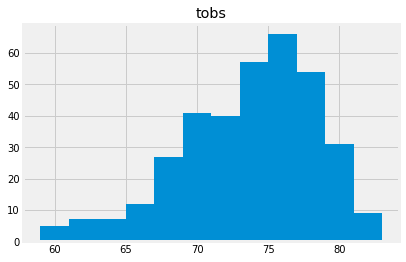

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

highest_tobs = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()[0][0]
last_tobs = session.query(Measurement.date).filter(Measurement.station == highest_tobs).order_by(Measurement.date.desc()).all()[0][0]
last_year_tobs = dt.datetime.strptime(last_tobs, '%Y-%m-%d') - dt.timedelta(days=365)
tobs_data = session.query(Measurement.tobs).filter(Measurement.station == highest_tobs).filter(Measurement.date >= last_year_tobs).all()
tobs_df = pd.DataFrame(tobs_data)
tobs_df.hist(bins=12)
plt.show()

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

trip_start, trip_end = '2020-03-01', '2020-03-10'
data_start = dt.datetime.strptime(trip_start, '%Y-%m-%d') - dt.timedelta(days=3*365)
data_end = dt.datetime.strptime(trip_end, '%Y-%m-%d') - dt.timedelta(days=3*365)
trip_data = calc_temps(data_start, data_end)

print(trip_data)

[(62.0, 70.77777777777777, 82.0)]


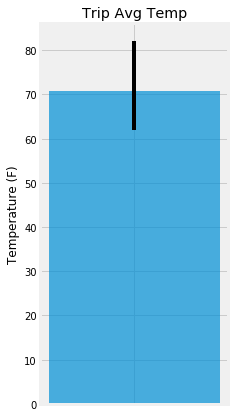

In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

min_err = trip_data[0][1]-trip_data[0][0]
max_err = trip_data[0][2]-trip_data[0][1]
plt.figure(figsize=(3,7))
plt.bar(x='', height=trip_data[0][1], alpha=0.7, yerr=[[min_err], [max_err]])
plt.title('Trip Avg Temp')
plt.ylabel('Temperature (F)')
plt.show()

In [20]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

station_rainfall = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).filter(Station.station == Measurement.station).filter(Measurement.date >= data_start).filter(Measurement.date <= data_end).group_by(Station.station).all()
statrain_df = pd.DataFrame(station_rainfall, columns=['Station', 'Name', 'Lat', 'Lng', 'Elv', 'Total Rainfall']).set_index('Station')
statrain_df

,Name,Lat,Lng,Elv,Total Rainfall
Station,,,,,
USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,2.11
USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.63
USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.92
USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.14
USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,1.40
USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.82
USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.25


In [21]:
session.close()